# Experimental Analysis

### Imports

In [1]:
from datasets import load_dataset 
import CodeSyntaxConcept.utils as utils
from CodeSyntaxConcept.tokenizer import CodeTokenizer
from CodeSyntaxConcept.parser import TreeSitterParser
import pandas as pd
import seaborn as sns
from statistics import mean, median, stdev


/home/svelascodimate/miniconda3/envs/code-syntax-concept/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Parameters

In [2]:
checkpoint = "himanshu-dutta/pycoder-gpt2"   #Checkpoint is irrelevant in this analysis, we use it to instantiate CodeTokenizer
number_of_samples = 10000
language = "python"
#save_path = "../experimental_notebooks/exploratory_experiments"

### Load Samples

In [3]:
test_set = load_dataset("code_search_net", split='test')
test_set = test_set.filter(lambda sample: True if 
                sample['language']== language 
            else False, num_proc=1)
test_set = utils.get_random_sub_set_test_set(test_set, number_of_samples)

No config specified, defaulting to: code_search_net/all
Found cached dataset code_search_net (/home/svelascodimate/.cache/huggingface/datasets/code_search_net/all/1.0.0/80a244ab541c6b2125350b764dc5c2b715f65f00de7a56107a28915fac173a27)
Loading cached processed dataset at /home/svelascodimate/.cache/huggingface/datasets/code_search_net/all/1.0.0/80a244ab541c6b2125350b764dc5c2b715f65f00de7a56107a28915fac173a27/cache-3fbe88ea46cf0b42.arrow


### Mapping Concepts

In [4]:
parser = TreeSitterParser(CodeTokenizer.from_pretrained(checkpoint,language))
test_set_node_counts = [()]*len(parser.tokenizer.node_types)

parent_node_types = set()

for sample in test_set:
    tree = parser.tokenizer.parser.parse(bytes(sample['whole_func_string'], "utf8"))

    sample_parent_nodes = []
    utils.find_parent_nodes(tree.root_node, sample_parent_nodes)
    parent_node_types.update([parent_node.type for parent_node in sample_parent_nodes])

    for ast_element in parser.tokenizer.node_types:
        ast_element_ocurrences = []
        utils.find_nodes(tree.root_node, ast_element, ast_element_ocurrences)
        test_set_node_counts[parser.tokenizer.node_types.index(ast_element)] = test_set_node_counts[parser.tokenizer.node_types.index(ast_element)] + tuple([len(ast_element_ocurrences)])

### Counts Dataframe

In [5]:
node_counts_dataframe = pd.DataFrame([], columns=['ast_element', 'counts', 'leaf_node'])
for node_id, node_counts in enumerate(test_set_node_counts):
    node_counts_dataframe.loc[len(node_counts_dataframe.index)] = [parser.tokenizer.node_types[node_id], node_counts, False if parser.tokenizer.node_types[node_id] in parent_node_types else True]

node_counts_dataframe.head()

,ast_element,counts,leaf_node
0,}},"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",True
1,subscript,"(0, 12, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2,...",False
2,&,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",True
3,list_splat_pattern,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",False
4,dotted_name,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",False


### Loading Dataframe

In [6]:
#node_counts_dataframe = pd.read_csv('exploratory_experiments/ea_EleutherAI-gpt-neo-1.3B.csv')

### Statisctics 

In [7]:
#node_counts_dataframe = node_counts_dataframe.drop('Unnamed: 0', axis=1)
node_counts_dataframe

,ast_element,counts,leaf_node
0,}},"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",True
1,subscript,"(0, 12, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2,...",False
2,&,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",True
3,list_splat_pattern,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",False
4,dotted_name,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",False
...,...,...,...
191,list_comprehension,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",False
192,return,"(0, 0, 2, 1, 1, 0, 0, 2, 2, 1, 1, 3, 0, 0, 1, ...",True
193,with_clause,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, ...",False
194,import,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",True


In [8]:
node_counts_dataframe['average'] = node_counts_dataframe['counts'].map(lambda counts: mean(counts))
node_counts_dataframe['median'] = node_counts_dataframe['counts'].map(lambda counts: median(counts))
node_counts_dataframe['stdev'] = node_counts_dataframe['counts'].map(lambda counts: stdev(counts))
node_counts_dataframe

,ast_element,counts,leaf_node,average,median,stdev
0,}},"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",True,0.0000,0.0,0.000000
1,subscript,"(0, 12, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2,...",False,1.7200,0.0,4.756455
2,&,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",True,0.0188,0.0,0.304723
3,list_splat_pattern,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",False,0.0360,0.0,0.203735
4,dotted_name,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",False,0.0996,0.0,0.860206
...,...,...,...,...,...,...
191,list_comprehension,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",False,0.1337,0.0,0.543373
192,return,"(0, 0, 2, 1, 1, 0, 0, 2, 2, 1, 1, 3, 0, 0, 1, ...",True,1.1139,1.0,1.233888
193,with_clause,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, ...",False,0.0665,0.0,0.328768
194,import,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",True,0.0553,0.0,0.416724


### Visualization - LEAF NODES

In [9]:
leaf_nodes_dataframe = node_counts_dataframe[node_counts_dataframe['leaf_node'] == True] 

<AxesSubplot: title={'center': 'Top 30 More Frequent AST Types (Leaves)'}, xlabel='ast_element'>

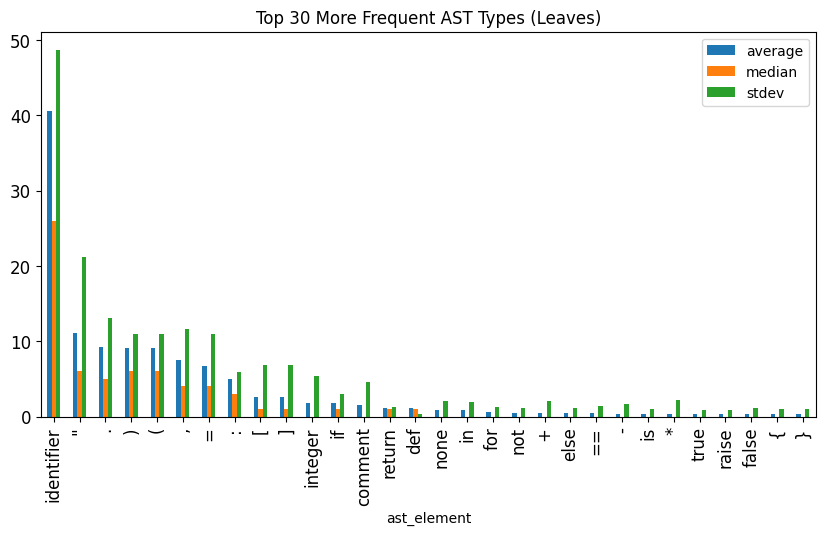

In [10]:
top_10 = leaf_nodes_dataframe.sort_values(by=['average'], ascending=False).head(30)
top_10.plot(x='ast_element',kind='bar',fontsize=12, title='Top 30 More Frequent AST Types (Leaves)', figsize=(10,5))

<AxesSubplot: title={'center': 'Top 30 Less Frequent Concepts (Leaves)'}, xlabel='ast_element'>

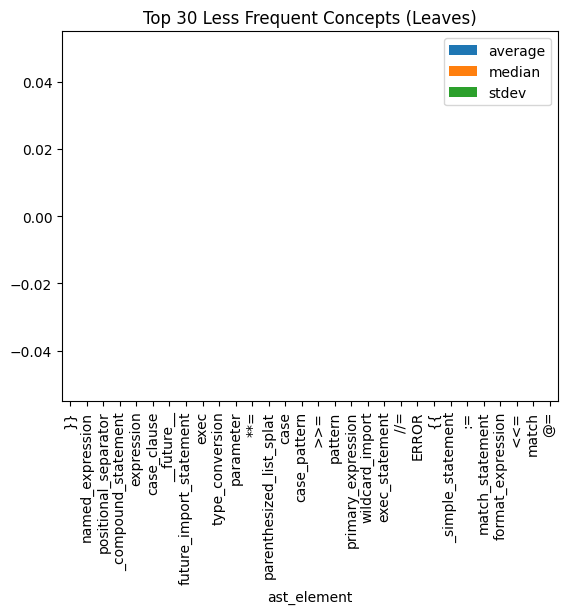

In [11]:
bottom_30 = leaf_nodes_dataframe.sort_values(by=['average'], ascending=True).head(30)
bottom_30.plot(x='ast_element',kind='bar', title='Top 30 Less Frequent Concepts (Leaves)')

### Visualization - PARENT NODES

In [12]:
parent_nodes_dataframe = node_counts_dataframe[node_counts_dataframe['leaf_node'] == False] 

<AxesSubplot: title={'center': 'Top 30 More Frequent AST Types (Parents)'}, xlabel='ast_element'>

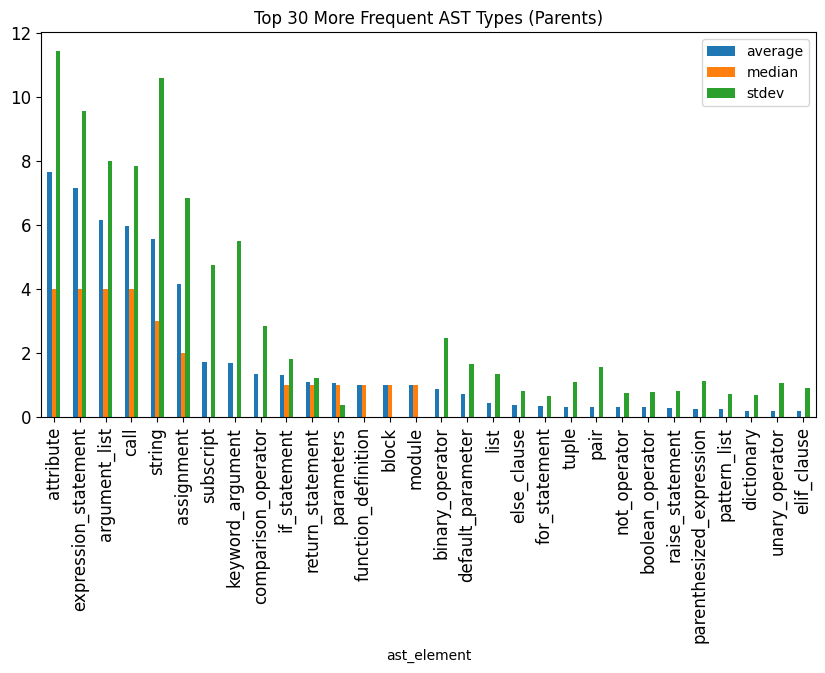

In [13]:
top_10 = parent_nodes_dataframe.sort_values(by=['average'], ascending=False).head(30)
top_10.plot(x='ast_element',kind='bar',fontsize=12, title='Top 30 More Frequent AST Types (Parents)', figsize=(10,5))

<AxesSubplot: title={'center': 'Top 30 Less Frequent Concepts (Parents)'}, xlabel='ast_element'>

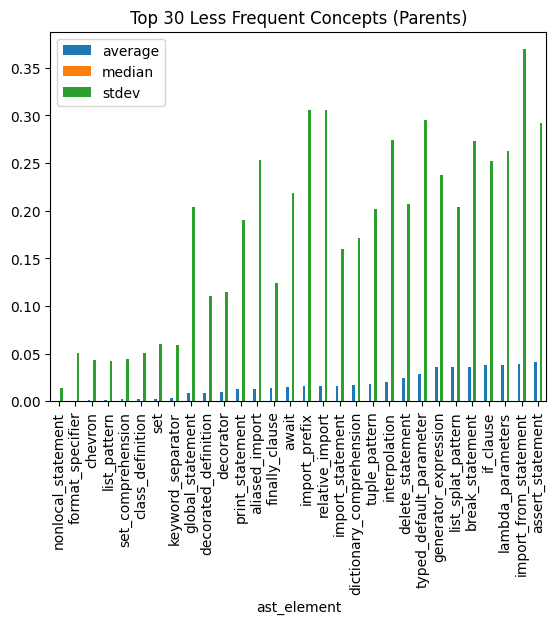

In [14]:
bottom_30 = parent_nodes_dataframe.sort_values(by=['average'], ascending=True).head(30)
bottom_30.plot(x='ast_element',kind='bar', title='Top 30 Less Frequent Concepts (Parents)')